# 1. 멀티턴 음성대화 데이터에서 개별 발화 .wav 추출

1. 음성 발화 구간 추출 및 분리된 .wav 파일 생성
필요한 라이브러리: pydub(오디오 처리), json, os.
JSON 파일의 Conversation 목록에서 StartTime, EndTime 값을 읽어 실제 음성 발화 구간을 추출.
원본 .wav 파일을 이 구간에 따라 자르고 개별 .wav 파일 생성.
파일명은 JSON의 TextNo나 Text를 기반으로 생성.
2. .csv 파일 생성
필요한 라이브러리: pandas.
JSON 파일에서 Text, StartTime, EndTime, SpeakerEmotionTarget, VerifyEmotionLevel 등 레이블링 데이터를 읽어 각 발화별 메타데이터를 추출.
이를 기반으로 모든 .wav 파일의 정보를 하나의 .csv 파일로 병합.

## 1) 환경설정

In [5]:
!pip install pydub

  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)


In [7]:
!apt-get clean
!apt-get update
!apt-get install ffmpeg -y


'apt-get'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [ ]:
from pydub import AudioSegment

# 오디오 파일 로드 
audio = AudioSegment.from_file("E:/AIFFELThon_data_SER/sample/감정이 태깅된 자유대화 (성인)/Sample/train/2_1373G2A4_1447G2A5_T1_2D07T0333C000478_005449")

# 오디오 파일의 일부 출력
print(audio.duration_seconds)

In [3]:
import zipfile
import os

# 압축파일 경로 및 해제 경로
zip_file_path = "/aiffel/aiffel/AIFFELThon/data/train.zip"  # 압축파일 경로
extract_to_dir = "/aiffel/aiffel/AIFFELThon/data/train_data"   # 압축 해제 경로

zip_labeling_path = "/aiffel/aiffel/AIFFELThon/data/train_labeling.zip"
extract_labeling_to_dir = "/aiffel/aiffel/AIFFELThon/data/train_labeling_data"

# 디렉토리가 없으면 생성
os.makedirs(extract_to_dir, exist_ok=True)
os.makedirs(extract_labeling_to_dir, exist_ok=True)

# ZIP 파일 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)

# ZIP 파일 해제
with zipfile.ZipFile(zip_labeling_path, 'r') as zip_ref:
    zip_ref.extractall(extract_labeling_to_dir)

print(f"Extracted {zip_file_path} to {extract_to_dir}")
print(f"Extracted {zip_labeling_path} to {extract_labeling_to_dir}")

Extracted /aiffel/aiffel/AIFFELThon/data/train.zip to /aiffel/aiffel/AIFFELThon/data/train_data
Extracted /aiffel/aiffel/AIFFELThon/data/train_labeling.zip to /aiffel/aiffel/AIFFELThon/data/train_labeling_data


## 2) 개별 발화 데이터로 분리

In [15]:
# import os
import json
from pydub import AudioSegment
import pandas as pd

# 입력 및 출력 경로 설정
wav_folder = "/aiffel/aiffel/AIFFELThon/data/train_data/"
json_folder = "/aiffel/aiffel/AIFFELThon/data/train_labeling_data/"
output_wav_folder = "split_wav_files/"
os.makedirs(output_wav_folder, exist_ok=True)

csv_data = []

# 폴더 내 모든 .wav 파일 순회
for wav_file in os.listdir(wav_folder):
    if wav_file.endswith(".wav"):
        base_name = os.path.splitext(wav_file)[0]
        wav_path = os.path.join(wav_folder, wav_file)
        json_path = os.path.join(json_folder, f"{base_name}.json")
        
        # JSON 파일 읽기
        if not os.path.exists(json_path):
            print(f"JSON 파일이 누락됨: {json_path}")
            continue
        with open(json_path, "r", encoding="utf-8") as f:
            json_data = json.load(f)
        
        # WAV 파일 로드
        audio = AudioSegment.from_wav(wav_path)
        
        # JSON 데이터의 Conversation 정보를 사용하여 음성 발화 분리
        for convo in json_data["Conversation"]:
#             start_time = float(convo["StartTime"]) * 1000  # ms 단위로 변환
#             end_time = float(convo["EndTime"]) * 1000
            start_time = float(convo["StartTime"].replace(',', '')) * 1000  # 쉼표 제거 후 변환
            end_time = float(convo["EndTime"].replace(',', '')) * 1000

            # 발화 구간 추출
            split_audio = audio[start_time:end_time]
            
            # 분리된 WAV 파일 저장
            text_no = convo["TextNo"]
            split_wav_name = f"{base_name}_{text_no}.wav"
            split_wav_path = os.path.join(output_wav_folder, split_wav_name)
            split_audio.export(split_wav_path, format="wav")
            
            # CSV 데이터 생성
            # CSV 데이터 생성
            csv_data.append({
                "FileName": split_wav_name,
                "Text": convo["Text"],
                "StartTime": convo["StartTime"],
                "EndTime": convo["EndTime"],
                "SpeakerEmotionTarget": convo["SpeakerEmotionTarget"],
                "VerifyEmotionTarget": convo["VerifyEmotionTarget"],
                "SpeakerEmotionLevel": convo["SpeakerEmotionLevel"],
                "VerifyEmotionLevel": convo["VerifyEmotionLevel"],
                "SpeakerEmotionCategory": convo["SpeakerEmotionCategory"],
                "VerifyEmotionCategory": convo["VerifyEmotionCategory"],
                "SpeakerEmotionObject": convo["SpeakerEmotionObject"],
                "VerifyEmotionObject": convo["VerifyEmotionObject"]
            })


# CSV 파일 생성
csv_df = pd.DataFrame(csv_data)
csv_output_path = "/aiffel/aiffel/AIFFELThon/data/output.csv"
csv_df.to_csv(csv_output_path, index=False, encoding="utf-8-sig")
print(f"CSV 파일 생성 완료: {csv_output_path}")


CSV 파일 생성 완료: output.csv


### 감정 요소

SpeakerEmotionTarget: 화자가 느낀 감정의 대상.

VerifyEmotionTarget: 검증된 감정의 대상.

SpeakerEmotionLevel: 화자의 감정 강도.

VerifyEmotionLevel: 검증된 감정 강도.

SpeakerEmotionCategory: 화자의 감정 카테고리 (예: 긍정, 부정).

VerifyEmotionCategory: 검증된 감정 카테고리.

SpeakerEmotionObject: 화자의 감정 관련 객체.

VerifyEmotionObject: 검증된 감정 관련 객체.

### output 샘플

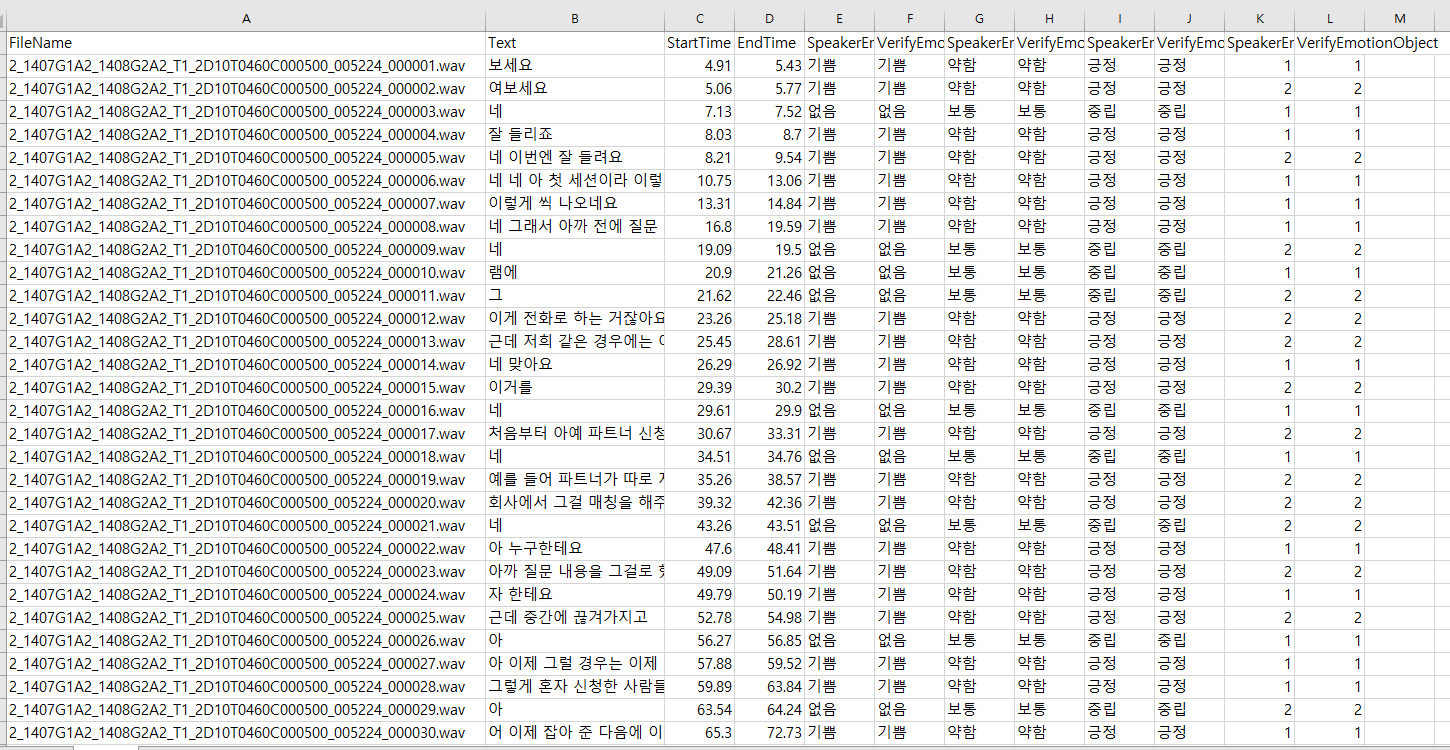